# Setup + Utils

In [81]:
import pyspark.sql.functions as F
from pyspark.sql import Row
import pyspark.sql.types as T
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from collections import Counter
from IPython.display import Markdown, display
from moztelemetry import Dataset
from pyspark.sql.window import Window

sc.setLogLevel("INFO")
sns.set(style='whitegrid')
% matplotlib inline

In [126]:
def md(md_text):
    """ Print Markdown text so that it renders correctly in the cell output. """
    display(Markdown(md_text))
    
    
def date_plus_x_days(date, x):
    new_date = dt.datetime.strptime(date, '%Y%m%d') + dt.timedelta(days=x)
    return new_date.strftime('%Y%m%d')

def _date_diff(d1, d2):
    if d1 and d2:
        try:
            d1, d2 = [pd.to_datetime(i, format="%Y%m%d") for i in (d1, d2)]
            return (d1 - d2).days
        except ValueError:
            pass
    return None
    

    return distinct_clients_that_installed, total_installs

def get_install_rates_disco(d, grouper=['branch']):
    # how many clients had 1+ install per branch
    installs = (
        d.filter("ping_type = 'install'")
         .filter("addon_id not like '%mozilla%'")
         .filter("src = 'about:addons'")
    )
    
    distinct_clients_that_installed = (
         installs
         .groupby(grouper)
         .agg(F.countDistinct('client_id')
               .alias("distinct_clients_that_installed"))
         .toPandas()
    )

    # total installs per branch
    total_installs = (
         installs
         .select(["client_id", "addon_id"] + grouper)
         .distinct()
         .groupby(grouper)
         .agg(F.count(F.lit(1)).alias("total_installs"))
         .toPandas()
    )
    
    # total distinct clients
    total_counts = (
        d.select(["client_id"] + grouper)
         .filter("discopane_loaded = true")
         .distinct()
         .groupby(grouper).count().toPandas()
    )
    
    
    total_counts.columns = grouper +  ['total_distinct_clients']

    # join for getting proportions
    m = (
        pd.merge(
            pd.merge(distinct_clients_that_installed, 
                     total_installs, on=grouper), 
            total_counts, on=grouper)
    )
    
    m['prob_at_least_one_install'] = m.distinct_clients_that_installed / m.total_distinct_clients
    m['n_installs_per_client']  = m.total_installs / m.total_distinct_clients
    m['src'] = 'about:addons'
    return m

def get_install_rates_AMO_total(d, grouper=['branch'], saw_treatment=True):
     # how many clients had 1+ install per branch
        
    
    treatment_indicator = (
         d.groupby("client_id")
          .agg(F.max(bool2int('discopane_loaded')).alias('saw_treatment'))
    )
    
    d_group = d.join(treatment_indicator
                     .filter(treatment_indicator.saw_treatment == int(saw_treatment)),
                     on='client_id')
    
    if saw_treatment == False:
        # comparison by branch irrelevant 
        # if the sample never navigated to discopane
        d_group = d_group.withColumn("branch", F.lit("All"))
    
    installs = (
        d_group.filter("ping_type = 'install'")
         .filter("addon_id not like '%mozilla%'")
         .filter("src = 'AMO'")
    )
    
    
    distinct_clients_that_installed = (
         installs
         .groupby(grouper)
         .agg(F.countDistinct('client_id')
               .alias("distinct_clients_that_installed"))
         .toPandas()
    )

    # total installs per branch
    total_installs = (
         installs
         .select(["client_id", "addon_id"] + grouper)
         .distinct()
         .groupby(grouper)
         .agg(F.count(F.lit(1)).alias("total_installs"))
         .toPandas()
    )
    
    # total distinct clients
    total_counts = (
        d_group.select(["client_id"] + grouper)
         .distinct()
         .groupby(grouper).count().toPandas()
    )
    
    
    total_counts.columns = grouper +  ['total_distinct_clients']

    # join for getting proportions
    m = (
        pd.merge(
            pd.merge(distinct_clients_that_installed, 
                     total_installs, on=grouper), 
            total_counts, on=grouper)
    )
    
    m['prob_at_least_one_install'] = m.distinct_clients_that_installed / m.total_distinct_clients
    m['n_installs_per_client']  = m.total_installs / m.total_distinct_clients
    m['src'] = 'AMO'
    return m


def get_install_rates_disco_total(d, grouper=['branch']):
     # how many clients had 1+ install per branch
        
    
    treatment_indicator = (
         d.groupby("client_id")
          .agg(F.max(bool2int('discopane_loaded')).alias('saw_treatment'))
    )
    d_group = d.join(treatment_indicator
                     .filter(treatment_indicator.saw_treatment == False),
                     on='client_id')
    
    
    d_group = d_group.withColumn("branch", F.lit("All"))
    
    installs = (
        d_group.filter("ping_type = 'install'")
         .filter("addon_id not like '%mozilla%'")
         .filter("src = 'about:addons'")
    )
    
    
    distinct_clients_that_installed = (
         installs
         .groupby(grouper)
         .agg(F.countDistinct('client_id')
               .alias("distinct_clients_that_installed"))
         .toPandas()
    )

    # total installs per branch
    total_installs = (
         installs
         .select(["client_id", "addon_id"] + grouper)
         .distinct()
         .groupby(grouper)
         .agg(F.count(F.lit(1)).alias("total_installs"))
         .toPandas()
    )
    
    # total distinct clients
    total_counts = (
        d_group.select(["client_id"] + grouper)
         .distinct()
         .groupby(grouper).count().toPandas()
    )
    
    
    total_counts.columns = grouper +  ['total_distinct_clients']

    # join for getting proportions
    m = (
        pd.merge(
            pd.merge(distinct_clients_that_installed, 
                     total_installs, on=grouper), 
            total_counts, on=grouper)
    )
    
    m['prob_at_least_one_install'] = m.distinct_clients_that_installed / m.total_distinct_clients
    m['n_installs_per_client']  = m.total_installs / m.total_distinct_clients
    m['src'] = 'about:addons'
    return m

def get_visitation_rates(d, grouper=['branch']):
    visits = (
        d.filter("ping_type = 'disco-pane-loaded'")
         .filter("dwell_time > 0")
         .groupby(grouper).count().toPandas()
    )
    visits.columns = grouper +  ["total_visits"]

    total_counts = (
        d.select(["client_id"] + grouper)
         .filter("discopane_loaded = true")
          .distinct()
         .groupby(grouper).count().toPandas()
    )
    total_counts.columns = grouper +  ['total_distinct_clients']


    mv = pd.merge(visits, total_counts, on=grouper)
    mv['visits_per_client'] = mv.total_visits / mv.total_distinct_clients
    return mv


def get_uninstall_rates(d, grouper=['branch']):
    first_install = (
    d.filter("ping_type = 'install'")
     .filter("src = 'about:addons'")
         .filter("addon_id not like '%mozilla%'")
         .groupby("client_id").agg(F.min("submission_date_s3").alias("first_install_date"))
    ).cache()

    fields = ['client_id', 'addon_id'] + grouper

    installs = (
        d.filter("ping_type = 'install'")
         .filter("src = 'about:addons'")
         .filter("addon_id not like '%mozilla%'")
         .select(fields)
         .distinct()
    ).cache()


    installs_and_final_addons = (
        installs.groupby(["client_id"] + grouper)
                .agg(F.collect_set("addon_id").alias("installs"))
        .join(first_install, on='client_id')
        .join(d.groupby("client_id")
               .agg(F.max("submission_date_s3").alias("submission_date_s3"))
               .join(d.select("client_id", "submission_date_s3", F.explode("current_addons").alias("addon_id"))
                       .filter("addon_id not like '%mozilla%'"),
                    on=['client_id', 'submission_date_s3'])
               .withColumnRenamed("submission_date_s3", "last_ping")
               .groupby("client_id", "last_ping")
               .agg(F.collect_set("addon_id").alias("retained")),
              on='client_id')      
    )

    uninstalls = (
     installs_and_final_addons
        .filter("last_ping > first_install_date")
        .withColumn('not_retained', set_diff("installs", "retained")) 
        .select(grouper + [F.explode("not_retained")]) 
        .groupby(grouper)
        .agg(F.count(F.lit(1)).alias("n_installed"))
        .join(
          installs_and_final_addons
            .select(grouper + [F.explode("installs")]) 
            .groupby(grouper)
            .agg(F.count(F.lit(1)).alias("n_total")),
         on=grouper)
    ).toPandas()


    uninstalls['n_retained'] = uninstalls.n_total - uninstalls.n_installed
    uninstalls['addon_retention_rate'] = uninstalls.n_retained / uninstalls.n_total
    return uninstalls

def _format_creation_date(d):
    d = d.split('.')[0]
    return long(re.sub("[-T:]", '', d))

format_creation_date = F.udf(_format_creation_date, T.LongType())
set_diff = F.udf(lambda x, y: list(set(x) - set(y)), T.ArrayType(T.StringType()))
date_diff = F.udf(_date_diff, T.LongType())
branch_counts = lambda x: x.groupby('branch').agg(F.countDistinct("client_id")).toPandas()
bool2int = F.udf(lambda x: 1 if x else 0, T.IntegerType())

# Data Loading

In [148]:
S3_PATH = 's3://telemetry-test-bucket/bmiroglio/taar-v2/'
START_DATE = '20180312'
RELOAD_MS = False

data = sqlContext.read.parquet(S3_PATH)
exp_data = data.filter("submission_date_s3 >= '{}'".format(START_DATE))
N = exp_data.count()
print "n pings:", N
print "n clients:", exp_data.select("client_id").distinct().count()

branch_counts(exp_data)

n pings: 8762664
n clients: 3491762


,branch,count(DISTINCT client_id)
0,ensemble-taar,1163829
1,control,1165189
2,linear-taar,1162842


In [149]:
exp_data.printSchema()

root
 |-- addon_id: string (nullable = true)
 |-- clicked_button: boolean (nullable = true)
 |-- client_id: string (nullable = true)
 |-- creation_date: string (nullable = true)
 |-- current_addons: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- discopane_loaded: boolean (nullable = true)
 |-- dwell_time: long (nullable = true)
 |-- locale: string (nullable = true)
 |-- ping_type: string (nullable = true)
 |-- saw_popup: boolean (nullable = true)
 |-- src: string (nullable = true)
 |-- start_time_utc: long (nullable = true)
 |-- submission_date_s3: string (nullable = true)
 |-- branch: string (nullable = true)



# Cleaning

We must verify our assumptions and requirements about the experiment data before performing any analysis. Any clients that do not conform to these assumptions will be excluded. The code below continuously adds non-conforming `client_id`s to a blacklist.




#### Assumption: clients that installed from disco-pane have a true value for `discopane_loaded`

#### Assumption: Each client belongs to only one branch

In [150]:
w = Window.partitionBy("client_id").orderBy("creation_date_formatted")
cum = (F.sum('dwell_time').over(w))

cum_dwell = (exp_data.withColumn("creation_date_formatted", format_creation_date("creation_date"))
         .withColumn("dwell_time_cum", cum)
         .sort('client_id', 'creation_date_formatted')
         .select("client_id", 'creation_date_formatted', 
                 'creation_date', 'discopane_loaded', 'dwell_time_cum'))

exp_data = (
    exp_data.join(cum_dwell.select("client_id", 
                               'creation_date', 
                               'dwell_time_cum'),
                  on=['client_id', 'creation_date'])
            .withColumn("discopane_loaded", F.col('discopane_loaded') | (F.col('dwell_time_cum') > 0))
)

# initialize blacklist
# as clients shown to have installed from
# discopane without ever loading it (~400 pings, so small)
blacklist_clients = (
    exp_data.filter("ping_type='install' and src='about:addons' and discopane_loaded = false")
    .select("client_id").distinct()
)


#### Assumption: Each client belongs to only one branch

In [151]:
# count the number of distinct branches per client
multiple_cohort_clients = (
    exp_data.groupBy("client_id")
        .agg(F.collect_set("branch").alias("branches"))
        .withColumn("n_branches", F.size("branches"))
        .filter("n_branches > 1")
)

blacklist_clients = (
    blacklist_clients.unionAll(multiple_cohort_clients.select("client_id").distinct())
)

#### Assumption: Each client has a `profile_creation_date` within 21 days of their first experiment ping, **and** each client has not submitted a main ping > 21 days before their first experimental ping

Join with main_summary to get non-experiment history

In [152]:
try:
    # load pre-aggregated main_summary data from s3
    assert not RELOAD_MS
    ms_min_dates = (sqlContext.read
                    .parquet("s3://telemetry-test-bucket/taar/ms-min-dates/"))
    blacklist_clients = blacklist_clients.unionAll(sqlContext.read
                         .parquet("s3://telemetry-test-bucket/taar/blacklist-clients/")
                         .select('client_id').distinct())
    print "loading pre-aggregated datasets"
except:
    
    # load main_summary from 2 weeks before study start date
    ms = (
        sqlContext.read.option("mergeSchema", True)
                  .parquet("s3://telemetry-parquet/main_summary/v4")
                  .filter("submission_Date_s3 > '{}'".format(date_plus_x_days(START_DATE, -30)))
                  .filter("submission_date_s3 <= '{}'".format('20180415'))
                  .filter("app_name = 'Firefox'")
                  .filter("normalized_channel = 'release'")
                  .select("client_id", 
                          "profile_creation_date", 
                          'locale', 'profile_creation_date', "submission_date_s3", 
                          "sample_id", "active_addons", "apple_model_id", "memory_mb")
    )

    # clients with different locales, apple_model_id (null for PC)
    # or memory_mb are excluded. Potentially ignores clients
    # with new hardware.
    blacklist_clients = (
        ms.select("client_id", 'locale', 'apple_model_id', 'memory_mb').distinct()
          .groupby('client_id').agg(F.count(F.lit(1)).alias('count'))
    ).filter("count > 1").select("client_id", F.lit(1).alias("blacklist"))

    # get the min submission_date_s3 and min PCD (should be constant)
    # per client
    ms_min_dates = (
        ms.groupBy("client_id")
          .agg(F.min('profile_creation_date').alias('min_pcd'),
               F.min('submission_date_s3').alias("min_submission_date"))
    )
    
    # write to s3 for faster iterations moving forward
    (ms_min_dates
     .repartition(50)
     .write
     .mode("overwrite")
     .parquet("s3://telemetry-test-bucket/taar/ms-min-dates/"))

    # write to s3 for faster iterations moving forward
    (blacklist_clients
     .repartition(10)
     .write
     .mode("overwrite")
     .parquet("s3://telemetry-test-bucket/taar/blacklist-clients/"))


    

    
# join with blacklist clients, and filter clients
# with multiple locales, hardware ids and/or memory
joined = (
    exp_data.join(ms_min_dates, on='client_id', how='left')
        .withColumn("min_pcd", 
                    F.from_unixtime(F.col("min_pcd") * 60 * 60 * 24, 'yyyyMMdd'))
).cache()



loading pre-aggregated datasets


Calculate the distrbution of clients with a min(submission_date) within x days of the study

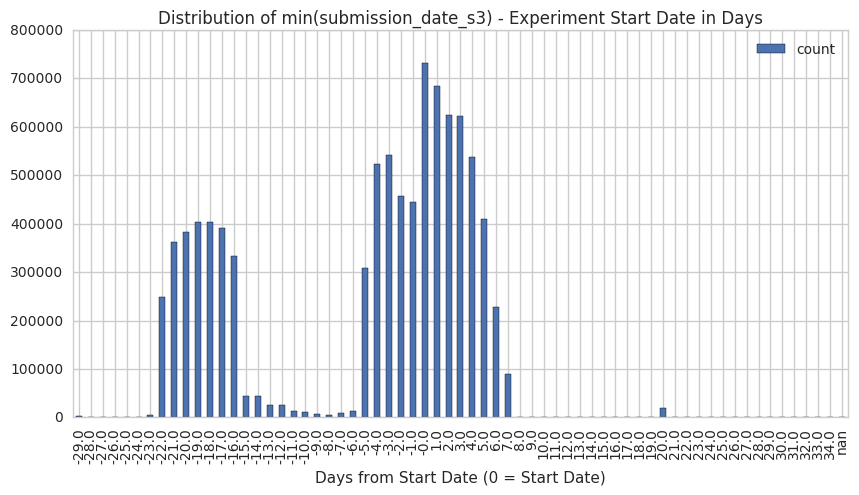

In [153]:
min_start_dates = joined.groupBy("client_id").agg(F.min("start_time_utc").alias("min_start_date"))

agg = (
    joined.join(min_start_dates, on="client_id")
            .withColumn("days_before_first_ping", date_diff("min_submission_date", "min_pcd"))
            .withColumn("days_before_exp_start", date_diff(F.lit(START_DATE), "min_submission_date"))
)

days_before = agg.groupby("days_before_exp_start").count().toPandas()
days_before['days_before_exp_start'] *= -1

plt.rcParams['figure.figsize'] = (10, 5)
days_before.sort_values("days_before_exp_start").plot.bar(x="days_before_exp_start")
plt.title("Distribution of min(submission_date_s3) - Experiment Start Date in Days")
plt.xlabel("Days from Start Date (0 = Start Date)")

Add to Blacklist

In [154]:
# no client should have a ping or pcd > 21 days from the experiment start date
# validating normandy targetting critera
blacklist_clients = blacklist_clients.unionAll((
    agg.filter("min_submission_date < '{}'".format(date_plus_x_days(START_DATE, -21)))
       .filter("min_pcd < '{}'".format(date_plus_x_days(START_DATE, -21)))
       .select("client_id").distinct()
)).distinct()

#### Requirement: No Firefox Pioneers

In [155]:
pioneers = (
    agg.select("client_id", F.explode("current_addons").alias("addon_id)"))
     .filter("addon_id like 'pioneer-enrollment%'")
     .select("client_id")
     .distinct()
)

blacklist_clients = blacklist_clients.unionAll(pioneers).distinct()

#### Black List and Whitelist Filtering

In [156]:
%%bash
# loading whitelists/blacklists generated here: 
# https://dbc-caf9527b-e073.cloud.databricks.com/#notebook/10421/
aws s3 cp s3://net-mozaws-prod-us-west-2-pipeline-analysis/failed_dynamo_clients.csv .
aws s3 cp s3://net-mozaws-prod-us-west-2-pipeline-analysis/clients_served_linear.csv .
aws s3 cp s3://net-mozaws-prod-us-west-2-pipeline-analysis/clients_served_ensemble.csv .

download: s3://net-mozaws-prod-us-west-2-pipeline-analysis/failed_dynamo_clients.csv to ./failed_dynamo_clients.csv
download: s3://net-mozaws-prod-us-west-2-pipeline-analysis/clients_served_linear.csv to ./clients_served_linear.csv
download: s3://net-mozaws-prod-us-west-2-pipeline-analysis/clients_served_ensemble.csv to ./clients_served_ensemble.csv


In [157]:
load_list = (lambda x: sc.parallelize(list(pd.read_json(x)[0]))
                          .map(lambda x: Row(client_id=x))
                          .toDF())
def filter_bl(d, bl):
    return (
        d.join(bl.select("client_id", F.lit(1).alias("in_bl")),
               on="client_id", how='left')
         .filter("in_bl is null")
    )

In [158]:
# load whitelist and convert to SparkDF
linear_whitelist = load_list('clients_served_linear.csv').distinct()
ensemble_whitelist =  load_list('clients_served_ensemble.csv').distinct()
blacklist_clients = blacklist_clients.unionAll(load_list('failed_dynamo_clients.csv')).distinct()

print "Clients in the linear whitelist:", linear_whitelist.count()
print "Clients in the ensemble whitelist:", ensemble_whitelist.count()
print "Clients in the blacklist:", blacklist_clients.count()

# filter out blacklist from master data
exp_data_bl = filter_bl(exp_data, blacklist_clients)


linear_filtered  = exp_data_bl.filter("branch = 'linear-taar'").join(linear_whitelist, on='client_id')
ensemble_filtered = exp_data_bl.filter("branch = 'ensemble-taar'").join(ensemble_whitelist, on='client_id')
control = exp_data_bl.filter("branch = 'control'")



cols=linear_filtered.columns

d_bl_wl = (
    linear_filtered
    .unionAll(ensemble_filtered.select(cols))
    .unionAll(control.select(cols))
)

d_bl_wl = d_bl_wl.withColumn('is_en_US', d_bl_wl.locale == 'en-US').cache()

Clients in the linear whitelist: 175911
Clients in the ensemble whitelist: 175321
Clients in the blacklist: 15524487


# Data Aggregation for Analysis



### Installation rates by branch / source

In [160]:
m = pd.concat([get_install_rates_disco(d_bl_wl),
               get_install_rates_AMO_total(d_bl_wl)])
m.to_csv("installs.csv", index=False)
m.sort_values(['src', 'branch'])
m

,branch,distinct_clients_that_installed,total_installs,total_distinct_clients,prob_at_least_one_install,n_installs_per_client,src
0,ensemble-taar,14453,19247,87914,0.164399,0.218930,about:addons
1,control,17181,24141,108958,0.157685,0.221562,about:addons
2,linear-taar,12015,17000,87664,0.137057,0.193922,about:addons
0,ensemble-taar,26914,44877,87914,0.306140,0.510465,AMO
1,control,33439,56123,108958,0.306898,0.515088,AMO
2,linear-taar,26731,44746,87664,0.304926,0.510426,AMO


In [161]:
baselines = pd.concat([get_install_rates_AMO_total(d_bl_wl, saw_treatment=False),
                       get_install_rates_disco_total(d_bl_wl)])

baselines.to_csv("baseline-installs.csv", index=False)
baselines

,branch,distinct_clients_that_installed,n_installs_per_client,prob_at_least_one_install,src,total_distinct_clients,total_installs
0,All,14049.0,0.01822,0.015452,AMO,909227,16566.0


In [162]:
%%bash
aws s3 cp installs.csv s3://telemetry-test-bucket/bmiroglio/taar-installs.csv
aws s3 cp baseline-installs.csv s3://telemetry-test-bucket/bmiroglio/taar-baseline-installs.csv

upload: ./installs.csv to s3://telemetry-test-bucket/bmiroglio/taar-installs.csv
upload: ./baseline-installs.csv to s3://telemetry-test-bucket/bmiroglio/taar-baseline-installs.csv


### Installation rates by branch / source / en-US vs. Non en-US

In [163]:
men = pd.concat([get_install_rates_disco(d_bl_wl, grouper=['branch', 'is_en_US']),
               get_install_rates_AMO_total(d_bl_wl, grouper=['branch', 'is_en_US'])])
men.to_csv("en-us-installs.csv", index=False)
men.sort_values(['src', 'branch'])
men

,branch,is_en_US,distinct_clients_that_installed,total_installs,total_distinct_clients,prob_at_least_one_install,n_installs_per_client,src
0,ensemble-taar,True,6432,8739,41239,0.155969,0.211911,about:addons
1,linear-taar,True,5608,8122,40786,0.137498,0.199137,about:addons
2,control,False,9349,12894,57640,0.162196,0.223699,about:addons
3,control,True,7832,11247,51347,0.152531,0.219039,about:addons
4,ensemble-taar,False,8021,10508,46700,0.171756,0.225011,about:addons
5,linear-taar,False,6407,8878,46899,0.136613,0.189300,about:addons
0,ensemble-taar,True,13173,22613,41244,0.319392,0.548274,AMO
1,linear-taar,True,12588,21790,40793,0.308582,0.534160,AMO
2,control,False,17444,28394,57651,0.302579,0.492515,AMO
3,control,True,15996,27729,51354,0.311485,0.539958,AMO


In [164]:
%%bash
aws s3 cp en-us-installs.csv s3://telemetry-test-bucket/bmiroglio/taar-en-us-installs.csv

upload: ./en-us-installs.csv to s3://telemetry-test-bucket/bmiroglio/taar-en-us-installs.csv


### Installation rates by branch / source / all locales

In [165]:
ml = pd.concat([get_install_rates_disco(d_bl_wl, grouper=['branch', 'locale']),
               get_install_rates_AMO_total(d_bl_wl, grouper=['branch', 'locale'])])
ml.to_csv("locale-installs.csv", index=False)
ml.sort_values(['src', 'branch'])
ml

,branch,locale,distinct_clients_that_installed,total_installs,total_distinct_clients,prob_at_least_one_install,n_installs_per_client,src
0,linear-taar,it,226,326,1961,0.115247,0.166242,about:addons
1,control,ru,1581,2151,8824,0.179170,0.243767,about:addons
2,linear-taar,de,1074,1414,8432,0.127372,0.167694,about:addons
3,ensemble-taar,fr,1161,1524,6526,0.177904,0.233527,about:addons
4,control,sr,21,41,113,0.185841,0.362832,about:addons
5,ensemble-taar,tr,231,338,1044,0.221264,0.323755,about:addons
6,linear-taar,el,19,27,157,0.121019,0.171975,about:addons
7,ensemble-taar,id,240,333,1100,0.218182,0.302727,about:addons
8,linear-taar,es-ES,730,1063,5179,0.140954,0.205252,about:addons
9,ensemble-taar,es-MX,1,1,2,0.500000,0.500000,about:addons


In [166]:
%%bash
aws s3 cp locale-installs.csv s3://telemetry-test-bucket/bmiroglio/taar-locale-installs.csv

upload: ./locale-installs.csv to s3://telemetry-test-bucket/bmiroglio/taar-locale-installs.csv


### Visitation rate to about:addons by branch

In [167]:
mv = get_visitation_rates(d_bl_wl)
mv.to_csv("visits.csv", index=False)
mv

,branch,total_visits,total_distinct_clients,visits_per_client
0,ensemble-taar,104933,87914,1.193587
1,control,114327,108958,1.049276
2,linear-taar,101832,87664,1.161617


### Visitation rate to about:addons by branch / en-US vs. Non en-US

In [168]:
mev = get_visitation_rates(d_bl_wl, grouper=['branch', 'is_en_US'])
mev.to_csv("en-us-visits.csv", index=False)
mev

,branch,is_en_US,total_visits,total_distinct_clients,visits_per_client
0,ensemble-taar,True,48804,41239,1.183443
1,linear-taar,True,46470,40786,1.139362
2,control,False,61509,57640,1.067124
3,control,True,52818,51347,1.028648
4,ensemble-taar,False,56129,46700,1.201906
5,linear-taar,False,55362,46899,1.180452


### Visitation rate to about:addons by branch / locale

In [169]:
mvl = get_visitation_rates(d_bl_wl, ['branch', 'locale'])
mvl.to_csv("locale-visits.csv", index=False)
mvl

,branch,locale,total_visits,total_distinct_clients,visits_per_client
0,linear-taar,it,2280,1961,1.162672
1,control,ru,9032,8824,1.023572
2,linear-taar,de,10087,8432,1.196276
3,ensemble-taar,fr,7460,6526,1.143120
4,control,sr,156,113,1.380531
5,ensemble-taar,tr,1217,1044,1.165709
6,linear-taar,el,180,157,1.146497
7,ensemble-taar,id,1723,1100,1.566364
8,linear-taar,es-ES,6914,5179,1.335007
9,ensemble-taar,es-MX,2,2,1.000000


In [170]:
%%bash
aws s3 cp visits.csv s3://telemetry-test-bucket/bmiroglio/taar-visits.csv
aws s3 cp en-us-visits.csv s3://telemetry-test-bucket/bmiroglio/taar-en-us-visits.csv
aws s3 cp locale-visits.csv s3://telemetry-test-bucket/bmiroglio/taar-locale-visits.csv

upload: ./visits.csv to s3://telemetry-test-bucket/bmiroglio/taar-visits.csv
upload: ./en-us-visits.csv to s3://telemetry-test-bucket/bmiroglio/taar-en-us-visits.csv
upload: ./locale-visits.csv to s3://telemetry-test-bucket/bmiroglio/taar-locale-visits.csv


### Add-on installations per Day/Branch

In [197]:
daily = (
    d_bl_wl.filter("ping_type = 'install' and addon_id not like '%mozilla%'")
     .groupby("submission_date_s3",'branch', "src")
     .agg(F.countDistinct("client_id").alias("count"))
).toPandas()


enrollment = (
    d_bl_wl.filter("ping_type='init'")
    .groupby("submission_date_s3")
    .agg(F.countDistinct("client_id").alias("count")).toPandas()
)

# daily.to_csv('daily_installs.csv', index=False)
# enrollment.to_csv("enrollment.csv", index=False)

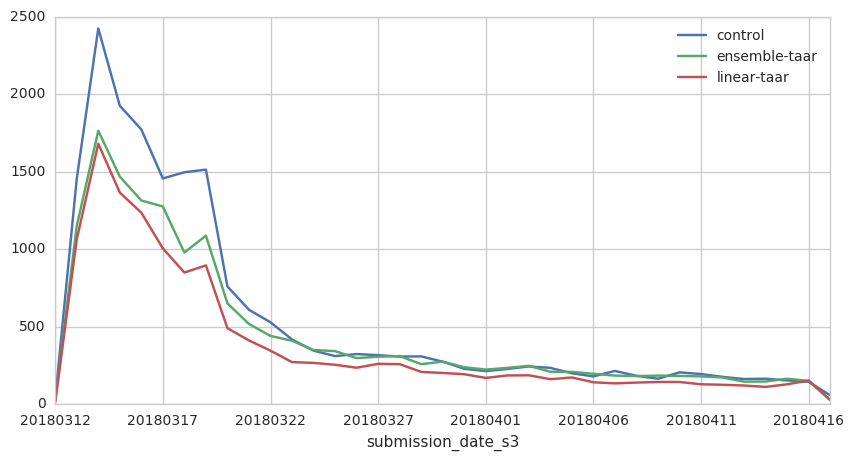

In [198]:
dd = daily[daily.src=='about:addons']
fig, ax = plt.subplots()
for g, data in dd.groupby('branch'):
    data.sort_values("submission_date_s3").plot(x='submission_date_s3', y='count', ax=ax, label=g)
plt.show()

In [194]:
dd

,submission_date_s3,branch,src,count
0,20180331,linear-taar,about:addons,287
1,20180404,linear-taar,about:addons,235
4,20180414,linear-taar,about:addons,163
7,20180324,control,about:addons,485
11,20180417,linear-taar,about:addons,36
15,20180403,control,about:addons,307
16,20180415,linear-taar,about:addons,175
17,20180318,ensemble-taar,about:addons,1287
18,20180403,ensemble-taar,about:addons,333
21,20180403,linear-taar,about:addons,288


In [187]:
%%bash
aws s3 cp daily_installs.csv s3://telemetry-test-bucket/bmiroglio/daily_installs.csv
aws s3 cp enrollment.csv s3://telemetry-test-bucket/bmiroglio/enrollment.csv

upload: ./daily_installs.csv to s3://telemetry-test-bucket/bmiroglio/daily_installs.csv
upload: ./enrollment.csv to s3://telemetry-test-bucket/bmiroglio/enrollment.csv


### Old UI vs New UI click through rate

Load pings from portion of the experiment with the old UI (excluded in all prior cells)

In [173]:
def collapse_fields(x):
    """
    Collapsed nested field names 
    and returns a flattened object as a 
    PySpark Row to prepare for DataFrame 
    conversion
    """
    if x is None:
        x = {}
    data = x.get("payload", {}).get("data").get("attributes", {})
    addons= x.get("environment", {}).get("addons", {}).get("activeAddons", {})
    result = Row(
        client_id=x.get("clientId"),
        locale=x.get("environment", {}).get("settings", {}).get("locale"),
        branch=x.get("payload", {}).get("branch"),
        addon_id=data.get("addon_id"),
        clicked_button=data.get("clickedButton"))
    return result

old_ui = (
    Dataset.from_source("telemetry")
           .where(docType="shield-study-addon")
           .where(submissionDate=lambda x: x < START_DATE and x >= '20180305')
           .records(sc)
           .filter(lambda x: x.get("payload", {}).get("study_name") == "TAARExperimentV2")
           .filter(lambda x: x.get("payload", {}).get("addon_version") == "1.0.11")
           .filter(lambda x: x.get("payload", {}).get("testing") == False)
).map(collapse_fields).toDF()


old_clicked = old_ui.filter("clicked_button=true").select('client_id').distinct().count()
old_total = old_ui.select("client_id").distinct().count()

new_clicked = exp_data.filter("clicked_button=true").select('client_id').distinct().count()
new_total = exp_data.select("client_id").distinct().count()

fetching 3315.84379MB in 35981 files...


In [174]:
ctr = pd.DataFrame([[old_clicked, old_total], [new_clicked, new_total]])
ctr['branch'] = ['old', 'new']
ctr.columns = ['n_clicked', 'n_total', 'branch']

ctr['prob_click'] = ctr.n_clicked / ctr.n_total
ctr.to_csv("ctr.csv", index=False)
ctr

,n_clicked,n_total,branch,prob_click
0,53001,1705341,old,0.031079
1,114867,3491762,new,0.032897


In [175]:
%%bash
aws s3 cp ctr.csv s3://telemetry-test-bucket/bmiroglio/ctr.csv

upload: ./ctr.csv to s3://telemetry-test-bucket/bmiroglio/ctr.csv 


### Old UI vs New UI click through rate by en-US / Non en-US

In [176]:
old_ui = old_ui.withColumn("is_en_US", old_ui.locale == 'en-US')
exp_data = exp_data.withColumn("is_en_US", exp_data.locale == 'en-US')


old_ctr = (
    old_ui.filter("clicked_button = true")
          .groupby("is_en_US")
          .agg(F.countDistinct("client_id").alias("n_clicked"))
    .join(
    old_ui.groupby("is_en_US")
          .agg(F.countDistinct("client_id").alias("n_total")),
    on='is_en_US')
).toPandas()

old_ctr['branch'] = 'old'

new_ctr = (
    exp_data.filter("clicked_button = true")
          .groupby("is_en_US")
          .agg(F.countDistinct("client_id").alias("n_clicked"))
    .join(
    exp_data.groupby("is_en_US")
          .agg(F.countDistinct("client_id").alias("n_total")),
    on='is_en_US')
).toPandas()

new_ctr['branch'] = 'new'

ctr_en_us = pd.concat([old_ctr, new_ctr])
ctr_en_us['prob_click'] = ctr_en_us.n_clicked / ctr_en_us.n_total
ctr_en_us.to_csv("ctr-en-us.csv", index=False)
ctr_en_us


,is_en_US,n_clicked,n_total,branch,prob_click
0,True,25259,817055,old,0.030915
1,False,27855,890253,old,0.031289
0,True,57816,1707789,new,0.033854
1,False,57857,1801940,new,0.032108


In [177]:
%%bash

aws s3 cp ctr-en-us.csv s3://telemetry-test-bucket/bmiroglio/ctr-en-us.csv

upload: ./ctr-en-us.csv to s3://telemetry-test-bucket/bmiroglio/ctr-en-us.csv


### Old UI vs New UI click through rate by en-US / locale

In [181]:

old_ctr = (
    old_ui.filter("clicked_button = true")
          .groupby("locale")
          .agg(F.countDistinct("client_id").alias("n_clicked"))
    .join(
    old_ui.groupby("locale")
          .agg(F.countDistinct("client_id").alias("n_total")),
    on='locale')
).toPandas()

old_ctr['branch'] = 'old'

new_ctr = (
    exp_data.filter("clicked_button = true")
          .groupby("locale")
          .agg(F.countDistinct("client_id").alias("n_clicked"))
    .join(
    exp_data.groupby("locale")
          .agg(F.countDistinct("client_id").alias("n_total")),
    on='locale')
).toPandas()

new_ctr['branch'] = 'new'

In [180]:
ctr_locale = pd.concat([old_ctr, new_ctr])
ctr_locale['prob_click'] = ctr_locale.n_clicked / ctr_locale.n_total
ctr_locale.to_csv("ctr-locale.csv", index=False)
ctr_locale

,locale,n_clicked,n_total,branch,prob_click
0,vi,133,2356,old,0.056452
1,ro,224,5895,old,0.037998
2,sl,1,3,old,0.333333
3,es-ES,3860,103745,old,0.037207
4,lv,1,1,old,1.000000
5,pl,1492,61235,old,0.024365
6,sk,170,3845,old,0.044213
7,ko,279,6580,old,0.042401
8,ms,2,42,old,0.047619
9,uk,92,3458,old,0.026605


### Add-on Retention by branch

In [182]:
ret = get_uninstall_rates(d_bl_wl)
ret.to_csv("addon-retention.csv", index=False)
ret

,branch,n_installed,n_total,n_retained,addon_retention_rate
0,ensemble-taar,1216,19013,17797,0.936044
1,control,1446,23897,22451,0.939490
2,linear-taar,1247,16795,15548,0.925752


### Add-on Retention by branch / en-US vs. Non en-US

In [183]:
reten= get_uninstall_rates(d_bl_wl, grouper=['branch', 'is_en_US'])
reten.to_csv("addon-en-us-retention.csv", index=False)
reten

,branch,is_en_US,n_installed,n_total,n_retained,addon_retention_rate
0,ensemble-taar,True,563,8637,8074,0.934815
1,linear-taar,True,627,8031,7404,0.921928
2,control,False,757,12762,12005,0.940683
3,control,True,689,11135,10446,0.938123
4,ensemble-taar,False,653,10376,9723,0.937066
5,linear-taar,False,620,8764,8144,0.929256


### Add-on Retention by branch / locale

In [184]:
retl = get_uninstall_rates(d_bl_wl, grouper=['branch', 'locale'])
retl.to_csv("addon-locale-retention.csv", index=False)
retl

,branch,locale,n_installed,n_total,n_retained,addon_retention_rate
0,linear-taar,it,37,326,289,0.886503
1,control,ru,143,2132,1989,0.932927
2,linear-taar,de,81,1401,1320,0.942184
3,control,sr,12,41,29,0.707317
4,ensemble-taar,fr,104,1501,1397,0.930713
5,ensemble-taar,tr,24,330,306,0.927273
6,ensemble-taar,id,20,318,298,0.937107
7,linear-taar,es-ES,50,1054,1004,0.952562
8,control,da,1,39,38,0.974359
9,ensemble-taar,cs,5,153,148,0.967320


In [185]:
%%bash
aws s3 cp addon-retention.csv s3://telemetry-test-bucket/bmiroglio/addon-retention.csv
aws s3 cp addon-en-us-retention.csv s3://telemetry-test-bucket/bmiroglio/addon-en-us-retention.csv
aws s3 cp addon-locale-retention.csv s3://telemetry-test-bucket/bmiroglio/addon-locale-retention.csv

upload: ./addon-retention.csv to s3://telemetry-test-bucket/bmiroglio/addon-retention.csv
upload: ./addon-en-us-retention.csv to s3://telemetry-test-bucket/bmiroglio/addon-en-us-retention.csv
upload: ./addon-locale-retention.csv to s3://telemetry-test-bucket/bmiroglio/addon-locale-retention.csv
